## Pytorch

Usamos los datos de la siguiente página.

https://archive.ics.uci.edu/dataset/158/poker+hand

El conjunto describe manos en un juego de póker.  Cada mano es tomada de una baraja de 52 cartas.  Cada carta (o naipe) es descrita por dos atributos:
1. palo (_suite_): 1 - Corazón, 2 - Pica o espada, 3 - Diamante, 4 - Trébol; y
2. valor (_rank_), números del 1 al 13;
dando un total de 10 atributos.

El atributo en la última columna corresponde al tipo de mano, son números del 0 al 9 y este es el valor a predecir.

Solo se usará el archivo **poker-hand-testing.data** el cual dividiremos en los conjuntos de entrenamiento y validación.

Para instalar Pytorch puedes tu sistema operativo, tu instalador de paquetes de python y tus versiones, estaremos usando la versión 1.7.0 de pytorch, si tienes CUDA, también selecciona tu versión, en otro caso, 
puedes elegir None.

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('fivethirtyeight')

from IPython.core.pylabtools import figsize
figsize(11, 5)
colores = ["#348ABD", "#A60628","#06A628"]

In [10]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [11]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
#Definimos el dispositivo que se usará.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [12]:
import numpy as np

In [13]:
def get_data(path):
    '''
    Función para obtener las matrices de entrenamiento y de validación
    a partir de los datos que se encuentran en el archivo que se define en 
    el parámetro path.
    '''
    # Cargamos los datos desde el archivo
    data = np.loadtxt(path, delimiter=',')
    
    # Aleatorizamos los datos
    #np.random.shuffle(data)
    
    # Dividimos los datos en características (X) y etiquetas (Y)
    X = data[:, :-1]  # Todas las columnas excepto la ultima
    Y = data[:, -1]   # Ultima columna
    
    # Normalizacion de las caracteristicas :p
    # X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    # Definimos el tamaño del conjunto de entrenamiento
    train_size = int(0.99 * len(data))  # 90% para entrenamiento
    
    # Dividimos los datos en conjuntos de entrenamiento y validacion
    X_train = X[:train_size]
    Y_train = Y[:train_size]
    X_val = X[train_size:]
    Y_val = Y[train_size:]
    
    return X_train, Y_train, X_val, Y_val


In [14]:
data_path = './data/poker-hand-testing.data'
## Define una función para obtener los datos, revuelvelos 
## aleatoriamente y dividelos en los conjuntos de validación y 
## de entrenamiento.
X_train,Y_train,X_val,Y_val = get_data(data_path)

Usaremos la biblioteca nn de pytorch para definir nuestro modelo de red neuronal, puedes 
ver los tipos de capas, funciones de activación y funciones de error con las que 
disponemos viendo la documentación de pytorch. Busque la definición de 

https://pytorch.org/docs/stable/nn.html

In [15]:
import torch.nn.functional as F

In [16]:
class Poker(nn.Module):
    def __init__(self,input_size,hidden,output_size):
        '''
        Define las caracteristicas de una red completamente conectada 
        de tres capas, recibe la cantidad de elementos de entrada, el 
        número de capas ocultas y el número de elementos de salida. 
        Entre cada capa agrega una función de activación logistica.
        '''
        super(Poker,self).__init__()

        self.fc1 = nn.Linear(input_size,hidden)  # Capa de entrada
        self.fc2 = nn.Linear(hidden,hidden)      # Capa oculta
        self.fc3 = nn.Linear(hidden,output_size) # Capa de salida
        

        
    def feed_forward(self,X):
        '''
        Define una función que de como resultado realizar la propagación
        hacia adelante de los elementos de X en la red definida.
        '''

        # Propagación hacia adelante
        X = F.sigmoid(self.fc1(X))
        X = F.sigmoid(self.fc2(X))
        X = self.fc3(X)

        return X
        
    
    def back_propagate(self, X, Y, optimizer):
        '''
        Define una función que realice la propagación hacia atrás usando 
        la función de error de entropía cruzada y el optimizador proporcionado.
        '''

        # Convertir los datos a tensores
        inputs = Variable(torch.Tensor(X))
        targets = Variable(torch.LongTensor(Y))

        # Realizar la propagación hacia adelante
        outputs = self.feed_forward(inputs)

        # Inicializar el optimizador
        optimizer.zero_grad()

        # Calcular el error
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, targets)

        # Realizar la propagación hacia atrás y actualizar los pesos
        loss.backward()
        optimizer.step()
        
        
    def train(self, train_X, train_Y, optimizer, ciclos=100):
        '''
        Define una función de entrenamiento para la red, la cual utilice
        al conjunto de entrenamiento y el algoritmo de optimización que se 
        obtenga como parametro. Al finalizar los ciclos muestra la gráfica 
        del error.
        '''
        criterion = nn.CrossEntropyLoss()  # Función de pérdida de entropía cruzada
        errores = []  # Almacenar el error por ciclo
        
        for i in range(ciclos):
            # Convertir los datos a tensores de PyTorch
            inputs = Variable(torch.Tensor(train_X))
            targets = Variable(torch.LongTensor(train_Y))
            
            # Realizar la propagación hacia adelante
            outputs = self.feed_forward(inputs)
            
            # Calcular el error
            loss = criterion(outputs, targets)
            
            # Realizar la propagación hacia atrás y actualizar los pesos
            optimizer.zero_grad()      # Reiniciar los gradientes
            loss.backward()            # Calcular los gradientes
            optimizer.step()           # Actualizar los pesos
            
            # Guardar el error actual
            errores.append(loss.item())


        
        # Graficar el error
        plt.plot(range(ciclos), errores, color='#348ABD')
        plt.xlabel('Ciclo de entrenamiento')
        plt.ylabel('Error')
        plt.title('Entrenamiento de la red neuronal')
        plt.show()


        
    
                
    def confusion(self, test_X, test_Y):
        inputs = Variable(torch.Tensor(test_X))
        outputs = self.feed_forward(inputs)
        _, predicted = torch.max(outputs, 1)

        # Asegurar la codificación de las etiquetas
        test_Y = np.array(test_Y)
        predicted = predicted.numpy()

        # Inicializar la matriz de confusión con ceros
        num_classes = 2  # Solo dos clases: positiva y negativa
        cm = np.zeros((num_classes, num_classes), dtype=int)

        # Calcular la matriz de confusión simplificada
        for a, p in zip(test_Y, predicted):
            a = int(a)
            p = int(p)
            if a < num_classes and p < num_classes:  # Verificar si a y p están dentro de los límites
                cm[a][p] += 1

        # Calcular verdaderos positivos (TP), falsos positivos (FP),
        # verdaderos negativos (TN) y falsos negativos (FN)
        TP = np.diag(cm)
        FP = np.sum(cm, axis=0) - TP
        FN = np.sum(cm, axis=1) - TP
        TN = np.sum(cm) - (FP + FN + TP)

        # Calcular la precisión, sensibilidad y especificidad
        #precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        specificity = TN / (TN + FP)

        # Calcular la exactitud
        accuracy = (TP + TN) / (TP + TN + FP + FN)

        # Calcular la precisión global
        precision_global = np.sum(TP) / np.sum(TP + FP)

        # Calcular la sensibilidad global
        recall_global = np.sum(TP) / np.sum(TP + FN)

        # Calcular la especificidad global
        specificity_global = np.sum(TN) / np.sum(TN + FP)

        # Calcular la exactitud global
        accuracy_global = np.sum(TP + TN) / np.sum(TP + TN + FP + FN)

        # Imprimir los resultados
        print('Matriz de confusión:')
        print(cm)
        #print('Precisión:', precision)
        print('Sensibilidad:', recall)
        print('Especificidad:', specificity)
        print('Exactitud:', accuracy)
        print('Precisión global:', precision_global)
        print('Sensibilidad global:', recall_global)
        print('Especificidad global:', specificity_global)
        print('Exactitud global:', accuracy_global)

        # Graficar la matriz de confusión
        plt.matshow(cm, cmap=plt.cm.Blues)
        plt.colorbar()
        plt.xlabel('Valores predichos')
        plt.ylabel('Valores verdaderos')
        plt.title('Matriz de confusión')
        plt.show()

        
        

        
        


Usando la misma definición de la red podemos modificar fácilmente los algoritmos de optimización que 
usamos para su entrenamiento. Prueba los siguientes algoritmos de optimización con tus mismos datos 
y con la misma cantidad de iteraciones.

Las definiciones de estos algorimos las puedes ver en la documentación de pytorch

https://pytorch.org/docs/stable/optim.html

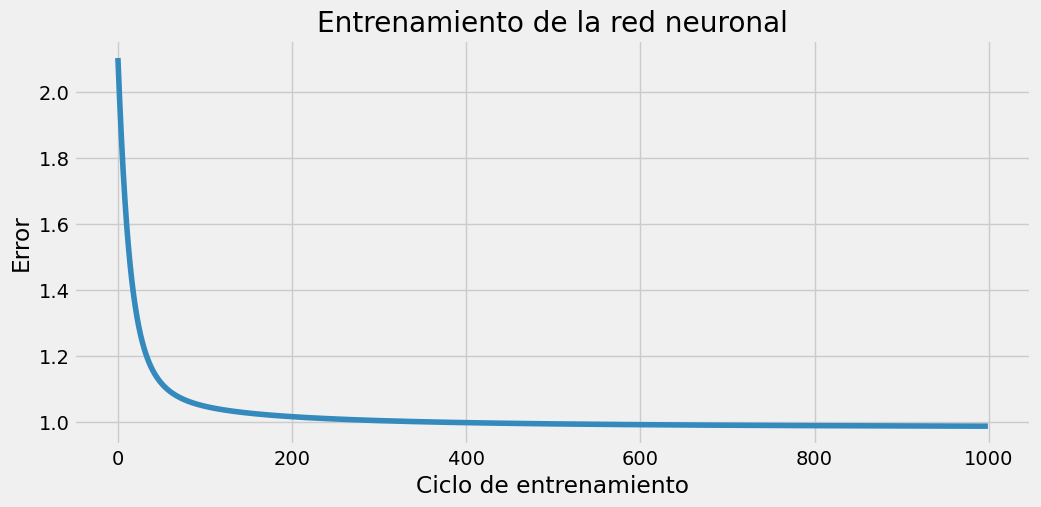

Matriz de confusión:
[[4982    0]
 [4244    0]]
Sensibilidad: [1. 0.]
Especificidad: [0. 1.]
Exactitud: [0.53999566 0.53999566]
Precisión global: 0.5399956644266204
Sensibilidad global: 0.5399956644266204
Especificidad global: 0.5399956644266204
Exactitud global: 0.5399956644266204


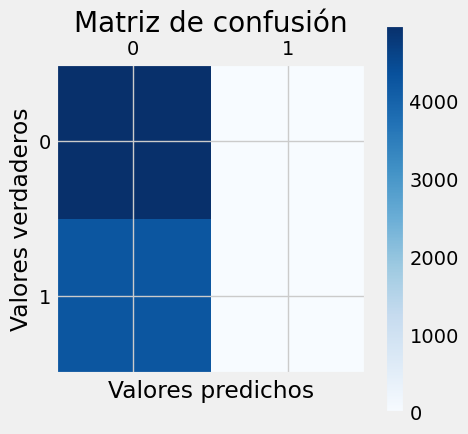

In [18]:
## Entrena una red utilizando el algoritmo de optimización de
## stochastic gradient descent y muestra la matriz de confusión

# Definir el tamaño de entrada, oculta y salida
input_sizeB = 10  # Tamaño de entrada
hidden_sizeB = 85  # Tamaño de la capa oculta
output_sizeB = 10  # Tamaño de salida (número de clases)

# Crear una instancia del modelo
modeloB = Poker(input_sizeB, hidden_sizeB, output_sizeB)

# Definir el optimizador (Stochastic Gradient Descent)
optimizer = optim.SGD(modeloB.parameters(), lr=0.01)

# Entrenar la red
modeloB.train(X_train, Y_train, optimizer, ciclos=1000)

# Mostrar la matriz de confusión
modeloB.confusion(X_val, Y_val)

# Con la anterior configuracion el tiempo de calculo fue de 34 minutos 30 segundos


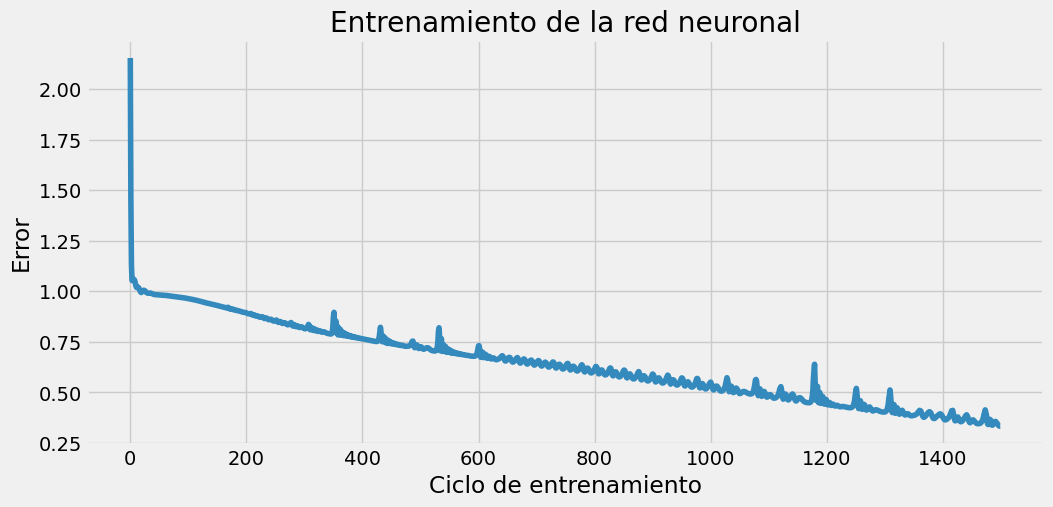

Matriz de confusión:
[[4806  176]
 [ 483 3761]]
Sensibilidad: [0.96467282 0.88619227]
Especificidad: [0.88619227 0.96467282]
Exactitud: [0.92857143 0.92857143]
Precisión global: 0.9285714285714286
Sensibilidad global: 0.9285714285714286
Especificidad global: 0.9285714285714286
Exactitud global: 0.9285714285714286


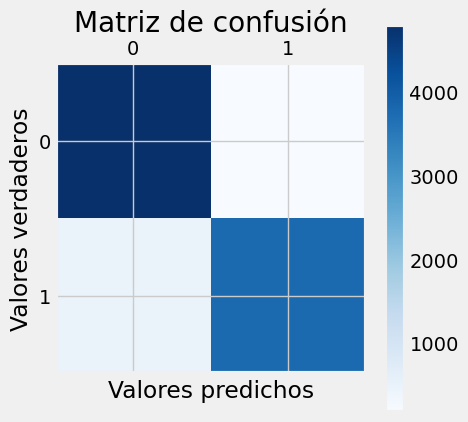

In [19]:
## Entrena una red utilizando el algoritmo de optimización Adam
## y muestra la matriz de confusión

# Definir el tamaño de entrada, oculta y salida
input_sizeA = 10  # Tamaño de entrada
hidden_sizeA = 85  # Tamaño de la capa oculta
output_sizeA = 10  # Tamaño de salida (número de clases)

# Crear una instancia del modelo
modeloA = Poker(input_sizeA, hidden_sizeA, output_sizeA)

# Definir el optimizador (Adam)
optimizerA = optim.Adam(modeloA.parameters(), lr=0.01)

# Entrenar la red
modeloA.train(X_train, Y_train, optimizerA, ciclos=1500)

# Mostrar la matriz de confusión
modeloA.confusion(X_val, Y_val)

# Con la anterior configuracion el tiempo de calculo fue de 52 minutos 59 segundos



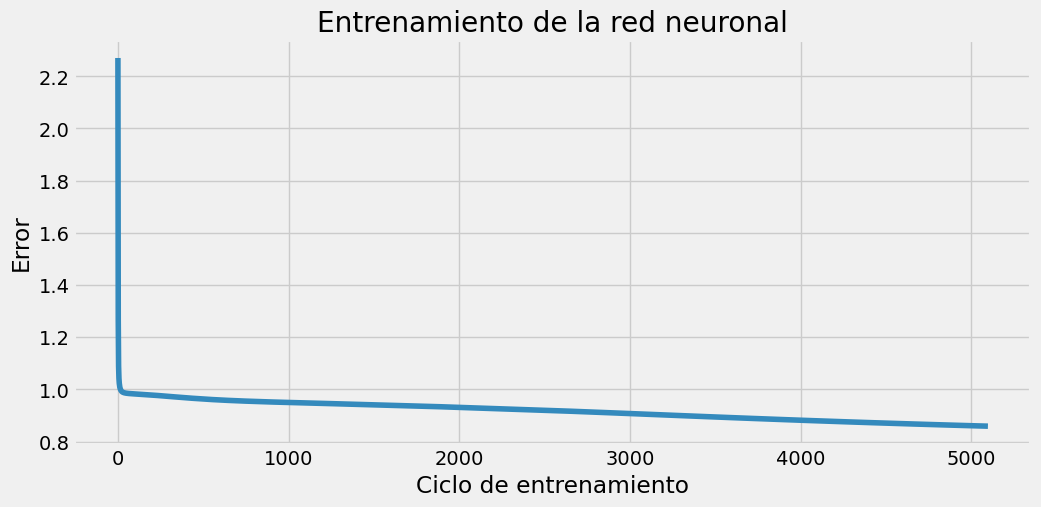

Matriz de confusión:
[[4109  873]
 [2291 1953]]
Sensibilidad: [0.82476917 0.46017908]
Especificidad: [0.46017908 0.82476917]
Exactitud: [0.65705615 0.65705615]
Precisión global: 0.6570561456752656
Sensibilidad global: 0.6570561456752656
Especificidad global: 0.6570561456752656
Exactitud global: 0.6570561456752656


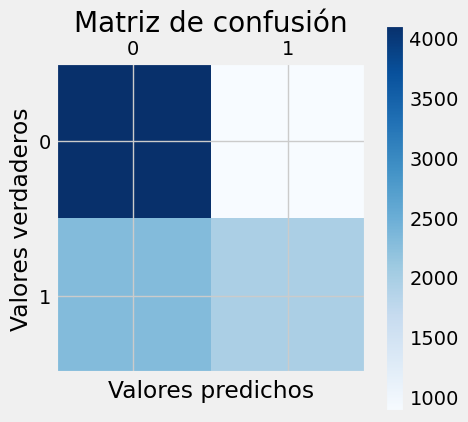

In [20]:
## Entrena una red utilizando el algoritmo de optmización Adagrad
## y muestra la matriz de confusión.

# Definir el tamaño de entrada, oculta y salida
input_sizeAd = 10  # Tamaño de entrada
hidden_sizeAd = 85  # Tamaño de la capa oculta
output_sizeAd = 10  # Tamaño de salida (número de clases)

# Crear una instancia del modelo
modeloAd = Poker(input_sizeAd, hidden_sizeAd, output_sizeAd)

# Definir el optimizador (Adagrad)
optimizerAd = optim.Adagrad(modeloAd.parameters(), lr=0.01)

# Entrenar la red
modeloAd.train(X_train, Y_train, optimizerAd, ciclos=5099)

# Mostrar la matriz de confusión
modeloAd.confusion(X_val, Y_val)

# Con la anterior configuracion el tiempo de calculo fue de 172 minutos 39 segundos

In [21]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()